# 1. Import and Install Dependencies

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from scipy import stats

# 2. Initial Function Definitions

In [2]:
#Defining mediapipe holistic model and model to draw landmarks

mpHolistic = mp.solutions.holistic 
mpDraw = mp.solutions.drawing_utils 

#Function to take in a frame as input, extract face, hand and pose landmarks and return it to the user

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image.flags.writeable = False                  
    results = model.process(image)                 
    image.flags.writeable = True                    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

#Function that takes image and its landmarks as input and uses the mediapipe drawing model to draw landmarks

def draw_landmarks(image, results):
    mpDraw.draw_landmarks(image, results.pose_landmarks, mpHolistic.POSE_CONNECTIONS,
                             mpDraw.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mpDraw.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mpDraw.draw_landmarks(image, results.left_hand_landmarks, mpHolistic.HAND_CONNECTIONS, 
                             mpDraw.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mpDraw.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mpDraw.draw_landmarks(image, results.right_hand_landmarks, mpHolistic.HAND_CONNECTIONS, 
                             mpDraw.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mpDraw.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

#Function to extract the keypoints from the face, hand and pose landmarks and return the values in one array

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

#Function to visualize and render the probability of a particular action live on the OpenCV display interface

colors = (117,245,16)

def prob_viz(action, input_frame, colors):
    output_frame = input_frame.copy()
    cv2.rectangle(output_frame, (0,60), (90), colors, -1)
    cv2.putText(output_frame, action, (0, 85), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)        
    return output_frame

# 3. Setup Folders for Collection

In [3]:
#Setting up storage spaces for storing each frame of data for every video for each action we are training the model on

try: 
    os.mkdir('MP_Data_new')
except:
    pass

DATA_PATH = os.path.join('MP_Data_new') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou', 'yes', 'no', 'please', 'yourewelcome', 'love', 'family'])

for action in actions:
    try: 
        os.makedirs(os.path.join(DATA_PATH, action))
    except:
        pass

numVids = 20

framesPerVid = 60

for action in actions: 
    for sequence in range(numVids):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass
i = 8

# 4. Collect Keypoint Values for Training and Testing

In [10]:
# #Collection of data on the keypoints and landmark positions for each sign language action in order to train the model on it

# cap = cv2.VideoCapture(0)
# action = actions[i]

# with mpHolistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
#     for sequence in range(numVids):
#         for frameNum in range(framesPerVid):
#             ret, frame = cap.read()
#             image, results = mediapipe_detection(frame, holistic)
#             draw_landmarks(image, results)

#             if frameNum == 0: 
#                 cv2.putText(image, 'STARTING COLLECTION', (150,200), 
#                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
#                 cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence + 1), (130,250), 
#                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
#                 cv2.imshow('OpenCV Feed', image)
#                 cv2.waitKey(1000)
#             else: 
#                 cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence + 1), (15,12), 
#                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
#                 cv2.imshow('OpenCV Feed', image)

#             keypoints = extract_keypoints(results)
#             npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frameNum))
#             np.save(npy_path, keypoints)

#             if cv2.waitKey(10) & 0xFF == ord('q'):
#                 break              
# cap.release()
# cv2.destroyAllWindows() 
# i+=1

# 5. Preprocess Data and Create Labels and Features

In [6]:
#Extracting the keypoint and landmark information for each action from its storage location and splitting all the data into respective training and testing datasets

label_map = {label:num for num, label in enumerate(actions)}
sequences, labels = [], []

for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frameNum in range(framesPerVid):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frameNum)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

X = np.array(sequences)
y = to_categorical(labels).astype(int)   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

# 6. Build and Train LSTM Neural Network, and evaluate the model to determine accuracy

In [ ]:
#Building the LSTM and Dense layers and training the model on the training dataset, as well as logging its live accuracy and loss percentage with each epoch

log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(60,258)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# %tensorboard --logdir logs
model.fit(X_train, y_train, epochs=200, callbacks=[tb_callback])
model.summary()

model.save('test.h5')

ytrue = np.argmax(y_test, axis=1).tolist()
ypred = np.argmax(model.predict(X_test), axis=1).tolist()

print(multilabel_confusion_matrix(ytrue, ypred))
print(accuracy_score(ytrue, ypred))

# 7. Applying model in real time to detect signs

In [ ]:
model.save('signlangnew.h5')

In [4]:
model = tf.keras.models.load_model('signlangnew.h5')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 60, 64)            82688     
                                                                 
 lstm_10 (LSTM)              (None, 60, 128)           98816     
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 9)                 297       
                                                                 
Total params: 237,449
Trainable params: 237,449
Non-tr

In [7]:
ytrue = np.argmax(y_test, axis=1).tolist()
ypred = np.argmax(model.predict(X_test), axis=1).tolist()

print(multilabel_confusion_matrix(ytrue, ypred))
print(accuracy_score(ytrue, ypred))

1/1 [==============================] - 0s 493ms/step
[[[23  0]
  [ 0  4]]

 [[24  2]
  [ 1  0]]

 [[24  0]
  [ 0  3]]

 [[24  0]
  [ 0  3]]

 [[22  0]
  [ 0  5]]

 [[24  1]
  [ 2  0]]

 [[26  0]
  [ 0  1]]

 [[25  0]
  [ 0  2]]

 [[21  0]
  [ 0  6]]]
0.8888888888888888


In [6]:
#Applying the model in real time to each frame of data recieved from the user in order to detect the signs being displayed
model = tf.keras.models.load_model('signlangnew.h5')
actions = np.array(['hello', 'thanks', 'iloveyou', 'yes', 'no', 'please', 'yourewelcome', 'love', 'family'])
sequence = []
sentence = ''
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
with mpHolistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        ret, frame = cap.read()
        image, results = mediapipe_detection(frame, holistic)
        draw_landmarks(image, results)
        
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        #print(len(sequence))
        sequence = sequence[-60:]
        #print(np.expand_dims(sequence, axis=0).shape)
        
        if len(sequence) == 60:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            #print(res)
            predictions.append(np.argmax(res))
            # print(predictions)
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold:                     
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence:
                            sentence = actions[np.argmax(res)]
                    else:
                        sentence = actions[np.argmax(res)]

            # if res[prediction] > threshold:                     
            #     if len(sentence) > 0: 
            #         if actions[np.argmax(res)] != sentence:
            #             sentence = actions[np.argmax(res)]
            #     else:
            #         sentence = actions[np.argmax(res)]
            # image = prob_viz(actions[np.argmax(res)], image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 39ms/step


In [39]:
cap.release()
cv2.destroyAllWindows() 

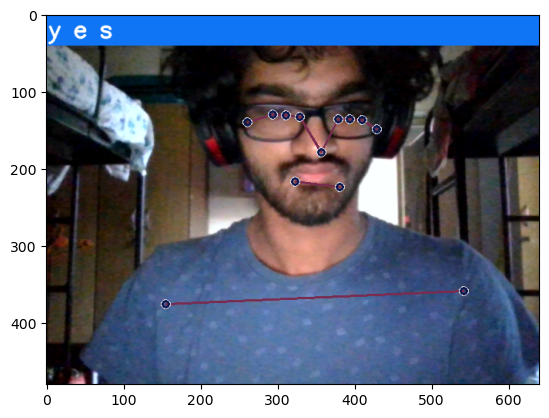

In [10]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))